In [1]:
#Вспомогательные инструменты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pickle

#Модели
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

#Метрики
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Графика
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Функции

In [2]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [3]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [4]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [5]:
df = pd.read_csv('data/data.csv',sep=';', low_memory=False)

удаляем лишние пробелы из названия колонок

In [6]:
df.columns = df.columns.str.replace(' ', '')

определяем датчики, которые подвергаются атакам

In [7]:
#Чтение файла

df2 = pd.read_excel('data/List_of_attacks_Final.xlsx')
df2 = df2.drop(df2[df2['Attack Point'].isna() == True].index)

Удаляем строки No Physical Impact Attack

In [8]:
df2 = df2.drop(df2[df2['Attack Point'] == 'No Physical Impact Attack'].index)

Получаем список уникальных значений из колонки Attack Point

In [9]:
print("количество датчиков, которые подвергаются атакам", len(df2['Attack Point'].unique()))
print()
print("Список датчиков")
print(df2['Attack Point'].unique())

количество датчиков, которые подвергаются атакам 28

Список датчиков
['MV-101' 'P-102' 'LIT-101' 'MV-504' 'AIT-202' 'LIT-301' 'DPIT-301'
 'FIT-401' 'MV-304' 'Mv-303' 'MV-303' 'AIT-504' 'MV-101, LIT-101'
 'UV-401, AIT-502, P-501' 'P-602, DIT-301, MV-302' 'P-203, P-205'
 'LIT-401, P-401' 'P-101, LIT-301' 'P-302, LIT-401' 'P-302'
 'P-201, P-203, P-205' 'LIT-101, P-101, MV-201' 'LIT-401' 'P-101'
 'P-101; P-102' 'P-501, FIT-502' 'AIT-402, AIT-502' 'FIT-401, AIT-502']


Отберем только те признаки датчиков, на которые совершались атаки

In [10]:
features = []

for col in df2['Attack Point'].unique():
    features += col.split(', ')

#уберем символ "-" из названия фичей и сделаем все буквы заглавными

for i in range(len(features)):
    features[i] = features[i].replace('-', "")
    features[i] = features[i].upper()
    
features = list(set(features))
print('Старый список')
print(features)
print()

features = [x for x in features if x in df.columns]
print('Новый список')
print(features)

Старый список
['FIT401', 'DIT301', 'P101', 'MV504', 'P205', 'LIT301', 'UV401', 'LIT401', 'P203', 'P302', 'FIT502', 'MV201', 'P201', 'MV304', 'P102', 'P602', 'AIT504', 'AIT502', 'MV302', 'AIT402', 'MV101', 'P401', 'P501', 'DPIT301', 'LIT101', 'P101; P102', 'AIT202', 'MV303']

Новый список
['FIT401', 'P101', 'P205', 'LIT301', 'UV401', 'LIT401', 'P203', 'P302', 'FIT502', 'MV201', 'P201', 'MV304', 'P102', 'P602', 'AIT504', 'AIT502', 'MV302', 'AIT402', 'MV101', 'P401', 'P501', 'DPIT301', 'LIT101', 'AIT202', 'MV303']


создадим новый датафрейм в котором будут только фичи из списка features

In [11]:
df_new = pd.DataFrame()

for colname in features:
    df_new[colname] = df[colname].copy()

Добавим к датасету целевую переменную, чтобы в случае удаления лишних строк, длины тренировочного набора и серия с меткой совпали

In [12]:
df_new['Normal/Attack'] = df['Normal/Attack'].copy()
df_new.head(5)

,FIT401,P101,P205,LIT301,UV401,LIT401,P203,P302,FIT502,MV201,...,MV302,AIT402,MV101,P401,P501,DPIT301,LIT101,AIT202,MV303,Normal/Attack
0,"1,713517",2,2,"956,1651",2,"942,0662",2,2,"1,279621",2,...,2,"156,0882",2,1,2,"19,74838","522,8467","8,396437",1,Normal
1,"1,715952",2,2,"956,1651",2,"942,0277",2,2,"1,297554",2,...,2,"156,0882",2,1,2,"19,74838","522,886","8,396437",1,Normal
2,"1,715952",2,2,"956,4855",2,"941,8739",2,2,"1,293967",2,...,2,"156,0882",2,1,2,"19,69076","522,8467","8,394514",1,Normal
3,"1,71467",2,2,"956,806",2,"941,797",2,2,"1,281158",2,...,2,"156,0882",2,1,2,"19,69076","522,9645","8,394514",1,Normal
4,"1,71467",2,2,"957,0864",2,"942,22",2,2,"1,281158",2,...,2,"156,0882",2,1,2,"19,69076","523,4748","8,394514",1,Normal


In [13]:
df_new.columns

Index(['FIT401', 'P101', 'P205', 'LIT301', 'UV401', 'LIT401', 'P203', 'P302',
       'FIT502', 'MV201', 'P201', 'MV304', 'P102', 'P602', 'AIT504', 'AIT502',
       'MV302', 'AIT402', 'MV101', 'P401', 'P501', 'DPIT301', 'LIT101',
       'AIT202', 'MV303', 'Normal/Attack'],
      dtype='object')

Убираем лишние пробелы из значений целевой переменной

In [14]:
df_new['Normal/Attack'] = df_new['Normal/Attack'].str.replace(' ', "")

In [15]:
unique_values = []

for column in df_new.columns:
    if len(df_new[column].unique()) < 2:
        df_new = df_new.drop(column, axis=1)

Получим список только с количественными переменными с уникальными значениями больше 3

In [16]:
num_cols = []

for columns in df_new.columns:
    if len(df_new[columns].unique())> 3:
        num_cols += [columns]

In [17]:
for num_col in num_cols:
    df_new[num_col] = df_new[num_col].str.replace(',', '.').astype('float')

In [18]:
df_new.isna().sum()

FIT401           0
P101             0
P205             0
LIT301           0
UV401            0
LIT401           0
P203             0
P302             0
FIT502           0
MV201            0
P201             0
MV304            0
P102             0
P602             0
AIT504           0
AIT502           0
MV302            0
AIT402           0
MV101            0
P501             0
DPIT301          0
LIT101           0
AIT202           0
MV303            0
Normal/Attack    0
dtype: int64

Построив сводную таблицу, мы видим, что в случае когда FIT401 = 0, в подавляющем числе случаев это признак атаки

In [19]:
pd.pivot_table(df_new[df_new.FIT401 == 0], values='FIT401',
                    columns=['Normal/Attack'], aggfunc='count')

Normal/Attack,Attack,Normal
FIT401,32758,104


А в случаях, когда FIT401 больше 0, в большинстве своем наблюдения имеют метку Normal

In [20]:
pd.pivot_table(df_new[df_new.FIT401 > 0], values='FIT401',
                    columns=['Normal/Attack'], aggfunc='count')

Normal/Attack,Attack,Normal
FIT401,21863,395194


посчитаем сколько строк с меткой Normal и Attack

In [21]:
print('с меткой Attack', len(df_new[df_new['Normal/Attack'] == 'Attack']))
print('с меткой Normal', len(df_new[df_new['Normal/Attack'] == 'Normal']))
print('Общее количество наблюдений', len(df_new))

с меткой Attack 54621
с меткой Normal 395298
Общее количество наблюдений 449919


<AxesSubplot:xlabel='Normal/Attack', ylabel='Count'>

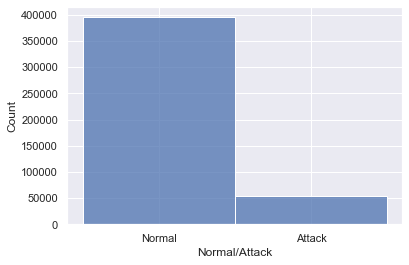

In [22]:
sns.histplot(data=df_new['Normal/Attack'])

Заменим в нашей целевой переменной метки Normal = 0, Attack = 1

In [23]:
df_new['Normal/Attack'] = df_new['Normal/Attack'].replace('Normal', 0)
df_new['Normal/Attack'] = df_new['Normal/Attack'].replace('Attack', 1)

Построим список наиболее коррелирующих между собой переменных

In [24]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_new[num_cols], 10))

Top Absolute Correlations
FIT401  FIT502    0.988298
FIT502  AIT402    0.972288
FIT401  AIT402    0.964281
AIT502  AIT402    0.945763
FIT502  AIT502    0.923177
FIT401  AIT502    0.921288
LIT401  FIT502    0.872888
FIT401  LIT401    0.859976
LIT401  AIT402    0.858061
        AIT502    0.815520
dtype: float64


<AxesSubplot:>

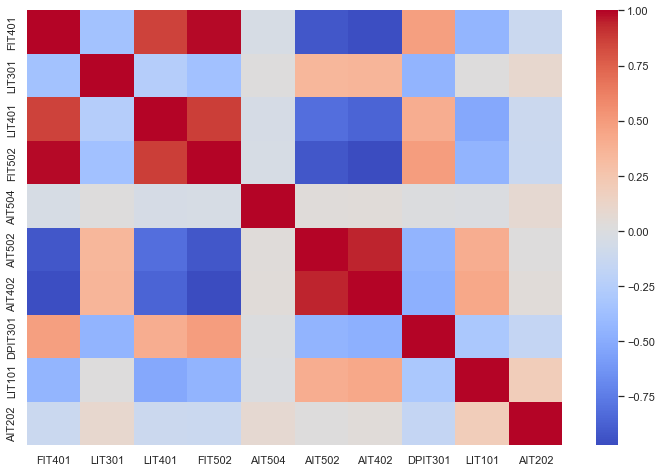

In [25]:
correlation = df_new[num_cols].corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation.head(10), annot = False, cmap = 'coolwarm')

МОДЕЛИРОВАНИЕ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

Логистическая регрессия или логит-модель (англ. logit model) — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой.

In [26]:
X = df_new.drop('Normal/Attack', axis=1).copy()
y = df_new['Normal/Attack'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled  = scaler.transform(X_test)

X_train.iloc[:] = X_train_scaled
X_test.iloc[:] = X_test_scaled

In [27]:
#@title Логистическая Регрессия{ run: "auto" }
#@markdown ### Тип Регуляризации 
penalty= 'l1' #@param [ "l2" , "l1", "none"]{type:"string"}
#@markdown ### Константа Регуларизации
regularization = 1.66 #@param {type:"slider", min:0.01, max:3, step:0.05}



LogReg = LogisticRegression(fit_intercept=True,
                            penalty=penalty,solver='saga',
                            C=regularization,
                            max_iter=100000)

LogReg.fit(X_train, y_train)

LogisticRegression(C=1.66, max_iter=100000, penalty='l1', solver='saga')

Код для сохранения обученной модели в RAW

In [28]:
y_predict=LogReg.predict(X_test)

print('test error')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='binary'))

test error
ACC: 0.9646
F1 : 0.8306


Графики основных метрик модели на основе логистической регресии

ROC кривая - отношение долей верно классифицированных меток 0 и верно классифицированных меток 1

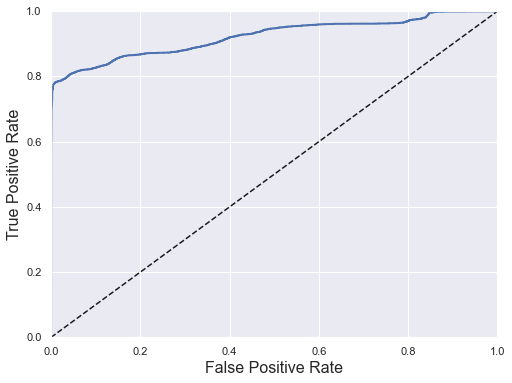

In [29]:
y_pred_proba = LogReg.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
target_names = ['normal', 'attack']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.96      1.00      0.98     39576
      attack       0.98      0.72      0.83      5416

    accuracy                           0.96     44992
   macro avg       0.97      0.86      0.91     44992
weighted avg       0.97      0.96      0.96     44992



ПОСТРОЕНИЕ ДЕРЕВА РЕШЕНИЙ

Обучение дерева решений использует дерево решений, чтобы перейти от наблюдений над объектами (представленными в ветвях) к заключениям о целевых значениях объектов (представленных в листьях)

Создаем словарь с параметрами, которые будет перебирать GridSearchCV

In [31]:
parametrs = {
    'n_estimators': [2,5],
    'max_features': ['sqrt'],
    'max_depth': [x for x in range(3, 5, 1)],
    'min_samples_split': [15,25],
    'min_samples_leaf': [1,2,5]
}

grid_search_reg = GridSearchCV(RandomForestClassifier(), parametrs, scoring = 'accuracy', cv=5, n_jobs=-1)
grid_search_reg.fit(X_train, y_train)
grid_search_reg.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 2}

In [32]:
y_predict = grid_search_reg.best_estimator_.predict(X_test)

Качество модели на метрике accuracy

In [33]:
print('accuracy:', acc(y_test, y_predict))

accuracy: 0.9597706258890469


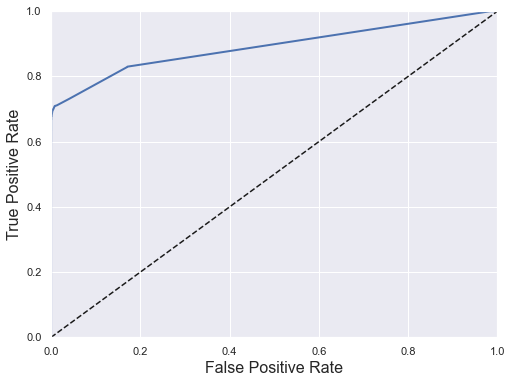

In [34]:
y_pred_proba = grid_search_reg.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
target_names = ['normal', 'attack']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.96      1.00      0.98     39576
      attack       1.00      0.67      0.80      5416

    accuracy                           0.96     44992
   macro avg       0.98      0.83      0.89     44992
weighted avg       0.96      0.96      0.96     44992



ПОСТРОЕНИЕ SVM МОДЕЛИ

Метод опорных векторов — набор схожих алгоритмов обучения с учителем, использующихся для задач классификации и регрессионного анализа. Принадлежит семейству линейных классификаторов и может также рассматриваться как частный случай регуляризации по Тихонову.

Обратить внимание, что SVM модель обучается относительно долго, поэтому был выбрана сокращенная обучающая выборка

In [36]:
C = 1.0  # = self._alpha in our algorithm
X_test_SVM = X_test.iloc[:10000,:]
y_test_SVM = y_test.iloc[:10000]
model1 = svm.SVC(kernel='linear', C=C, probability=True)

model1.fit(X_train.iloc[:50000,:], y_train.iloc[:50000])
y_predict = model1.predict(X_test_SVM)

print(acc(y_test_SVM, y_predict))

0.963


In [37]:
target_names = ['normal', 'attack']
print(classification_report(y_test.iloc[:10000], y_predict, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.96      1.00      0.98      8801
      attack       0.98      0.71      0.82      1199

    accuracy                           0.96     10000
   macro avg       0.97      0.85      0.90     10000
weighted avg       0.96      0.96      0.96     10000



ПОСТРОЕНИЕ SVM ONE-CLASS MODEL (ОБУЧЕНИЕ БЕЗ УЧИТЕЛЯ)

In [38]:
df_new.head()

,FIT401,P101,P205,LIT301,UV401,LIT401,P203,P302,FIT502,MV201,...,AIT502,MV302,AIT402,MV101,P501,DPIT301,LIT101,AIT202,MV303,Normal/Attack
0,1.713517,2,2,956.1651,2,942.0662,2,2,1.279621,2,...,145.1166,2,156.0882,2,2,19.74838,522.8467,8.396437,1,0
1,1.715952,2,2,956.1651,2,942.0277,2,2,1.297554,2,...,145.1166,2,156.0882,2,2,19.74838,522.8860,8.396437,1,0
2,1.715952,2,2,956.4855,2,941.8739,2,2,1.293967,2,...,145.1166,2,156.0882,2,2,19.69076,522.8467,8.394514,1,0
3,1.714670,2,2,956.8060,2,941.7970,2,2,1.281158,2,...,145.0141,2,156.0882,2,2,19.69076,522.9645,8.394514,1,0
4,1.714670,2,2,957.0864,2,942.2200,2,2,1.281158,2,...,144.8859,2,156.0882,2,2,19.69076,523.4748,8.394514,1,0


Исправим метки на 1(normal) и на -1(attack)

In [39]:
df_new['Normal/Attack'] = df_new['Normal/Attack'].replace(1, -1)
df_new['Normal/Attack'] = df_new['Normal/Attack'].replace(0, 1)

Обучать будем на обрезанном датасете, чтобы снизить время обучения

In [40]:
X = df_new.iloc[:50000].drop('Normal/Attack', axis=1)
y = df_new['Normal/Attack'].iloc[:50000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled  = scaler.transform(X_test)

X_train.iloc[:] = X_train_scaled
X_test.iloc[:] = X_test_scaled

Доля атак относительно общего количества наблюдений

In [41]:
outliers = df_new['Normal/Attack'][df_new['Normal/Attack'] == -1]
print(len(outliers))
normal = df_new['Normal/Attack'][df_new['Normal/Attack'] == 1]
print(len(normal))
ratio = round(len(outliers) / len(normal),2)
print(ratio)

54621
395298
0.14


In [42]:
nu = ratio
print("nu", nu)

model = svm.OneClassSVM(nu=nu, kernel='rbf', gamma=0.00005) 
model.fit(X_train)

nu 0.14


OneClassSVM(gamma=5e-05, nu=0.14)

In [43]:
y_predict = model.predict(X_test)
target_names = ['normal', 'attack']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.40      0.62      0.48       438
      attack       0.96      0.91      0.93      4562

    accuracy                           0.88      5000
   macro avg       0.68      0.77      0.71      5000
weighted avg       0.91      0.88      0.90      5000



In [44]:
print('ROC score')
round(roc_auc_score(y_test, y_predict),2)

ROC score


0.77